# 以LSTM/GRU演算法預測股價
### 程式修改自[Predicting stock prices with LSTM](https://medium.com/neuronio/predicting-stock-prices-with-lstm-349f5a0974d4)

In [1]:
# 載入相關套件
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 載入測試資料 -- 亞馬遜
df = pd.read_csv('../nlp_data/AMZN_2006-01-01_to_2018-01-01.csv', 
                 index_col='Date', parse_dates=['Date'])
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [3]:
df.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,AMZN
2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,AMZN
2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,AMZN
2017-12-28,1189.00,1190.10,1184.38,1186.10,1841676,AMZN
2017-12-29,1182.35,1184.00,1167.50,1169.47,2688391,AMZN


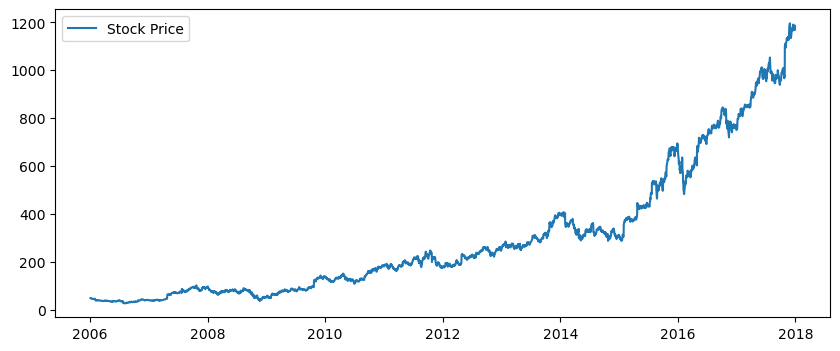

In [4]:
# 只使用收盤價
df = df['Close']

# 繪圖
plt.figure(figsize = (10, 4))
plt.plot(df, label='Stock Price')
plt.legend(loc='best')
plt.show()

## 參數設定

In [5]:
look_back = 1    # 以過去 1 期為特徵(X)
forward_days = 1 # 一次預測 1 天 (y)
num_periods = 20  # 測試資料量設定 20 期

In [6]:
# 特徵常態化
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = df.values.reshape(df.shape[0],1)
array = scl.fit_transform(array)

## 前置處理函數，取得特徵(X)與目標(Y)

In [7]:
# look_back：特徵(X)個數，forward_days：目標(y)個數，jump：移動視窗
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

## 資料切割成訓練資料及測試資料

In [8]:
division = len(array) - num_periods*forward_days
array_test = array[division-look_back:]
array_train = array[:division]

## 前置處理

In [9]:
X_train, y_train = processData(array_train,look_back,forward_days)
y_train = np.array([list(a.ravel()) for a in y_train])
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

In [10]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(2998, 1, 1)
(20, 1, 1)

(2998, 1)
(20, 1)


## 模型訓練

In [11]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 10

# 模型
model = Sequential()
model.add(Input((look_back,1)))
model.add(LSTM(NUM_NEURONS_FirstLayer, return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

# 訓練
history = model.fit(X_train,y_train,epochs=EPOCHS, verbose=2)

Epoch 1/10
94/94 - 1s - 16ms/step - loss: 0.0448
Epoch 2/10
94/94 - 0s - 2ms/step - loss: 0.0022
Epoch 3/10
94/94 - 0s - 4ms/step - loss: 3.0861e-04
Epoch 4/10
94/94 - 0s - 4ms/step - loss: 2.4272e-04
Epoch 5/10
94/94 - 0s - 2ms/step - loss: 1.7812e-04
Epoch 6/10
94/94 - 0s - 4ms/step - loss: 1.3105e-04
Epoch 7/10
94/94 - 0s - 4ms/step - loss: 9.5444e-05
Epoch 8/10
94/94 - 0s - 4ms/step - loss: 6.8331e-05
Epoch 9/10
94/94 - 0s - 4ms/step - loss: 5.2676e-05
Epoch 10/10
94/94 - 0s - 4ms/step - loss: 4.5095e-05


## 繪製損失函數

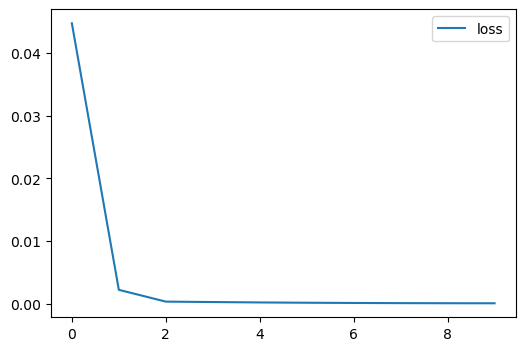

In [25]:
plt.figure(figsize = (6, 4))
plt.plot(history.history['loss'], label='loss')
plt.legend(loc='best')
plt.show()

In [14]:
model.save('./stock.keras')

## 測試資料預測

(20, 1)


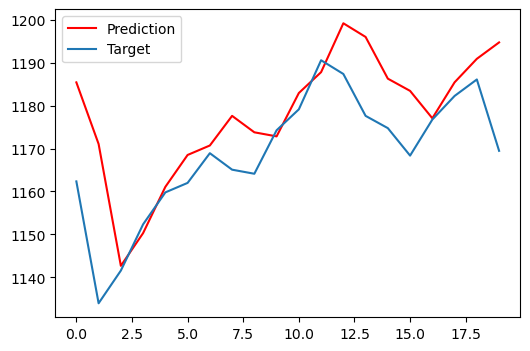

In [15]:
# 前置處理
X_test,y_test = processData(array_test,look_back,1,1)
y_test = np.array([list(a.ravel()) for a in y_test])
        
# 測試資料預測
Xt = model.predict(X_test, verbose=False)
Xt = Xt[:, 0]

# 繪製測試資料預測值
plt.figure(figsize = (6, 4))
plt.plot(scl.inverse_transform(Xt.reshape(-1,1)), color='r', label='Prediction')

# 繪製實際值
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

## 全部資料預測

In [16]:
division = len(array) - num_periods*forward_days
array_test = array[division-look_back:]
leftover = division%forward_days+1
array_train = array[leftover:division]
Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

# 預測
Xtrain = model.predict(Xtrain, verbose=False)
Xtrain = Xtrain.ravel() # 轉成一維

Xtest = model.predict(Xtest, verbose=False)
Xtest = Xtest.ravel() # 轉成一維

# 合併訓練資料與測試資料
y = np.concatenate((ytrain, ytest), axis=0)

## 繪圖

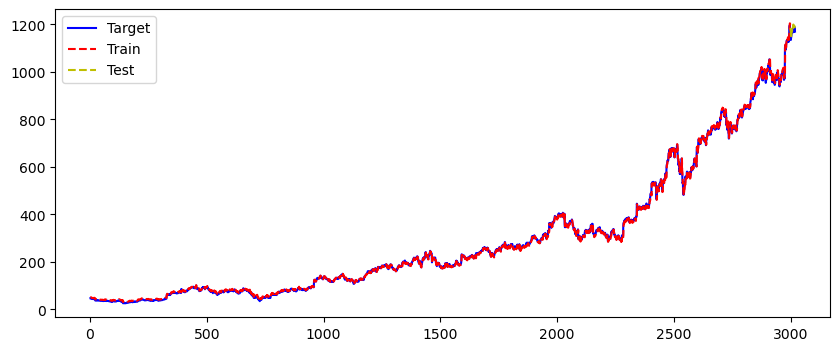

In [18]:
plt.figure(figsize = (10, 4))
# 繪製實際值
plt.plot([x for x in range(look_back+leftover, 
                           look_back+leftover+len(Xtrain)+len(Xtest))], 
         scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

# 繪製訓練資料預測值
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], 
         scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train', linestyle='--')

# 繪製測試資料預測值
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), 
         len(Xtrain)+len(Xtest)+look_back+leftover)], 
         scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test', linestyle='--')

plt.legend(loc='best')
plt.show()

## 拉近觀察

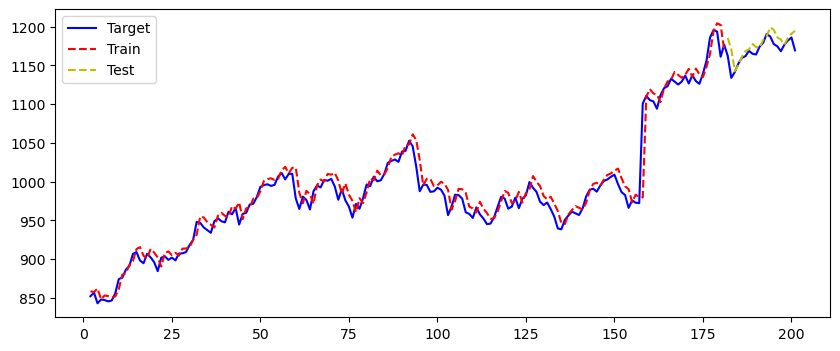

In [24]:
last_N_days = 200
# 繪製訓練資料預測值
plt.figure(figsize = (10, 4))
# 繪製實際值
plt.plot([x for x in range(look_back+leftover, 
                           look_back+leftover+last_N_days)], 
         scl.inverse_transform(y[-last_N_days:].reshape(-1,1)), color='b', label='Target')

# 繪製訓練資料預測值
plt.plot([x for x in range(look_back+leftover, look_back+leftover+last_N_days-len(Xtest))], 
         scl.inverse_transform(Xtrain[-last_N_days+len(Xtest):].reshape(-1,1)), 
         color='r', label='Train', linestyle='--')

# 繪製測試資料預測值
plt.plot([x for x in range(look_back +leftover+ last_N_days-len(Xtest), 
         look_back+leftover+last_N_days)], 
         scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test', linestyle='--')

plt.legend(loc='best')
plt.show()